# Coursera Courses Dataset - Exploratory Data Analysis

This notebook performs comprehensive EDA on the Coursera courses dataset.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Loading

In [2]:
# Load the dataset
df = pd.read_csv('../data/courses.csv')
print(f"Shape: {df.shape}")

Shape: (5411, 8)


## 13. Skills per Category Analysis

In [8]:
# Extract all skills from the dataset
all_skills = []
for skills in df['skills'].dropna():
    skill_list = [skill.strip() for skill in skills.split(',')]
    all_skills.extend(skill_list)

skills_series = pd.Series(all_skills)
top_skills = skills_series.value_counts().head(20)

print("Top 20 Most Common Skills:")
print(top_skills)

# Skills count per category
df['skills_count'] = df['skills'].str.split(',').str.len()

category_skills = df.groupby('category')['skills_count'].agg(['mean', 'median', 'max']).round(2)
category_skills = category_skills.sort_values('mean', ascending=False)

print("Skills Statistics by Category:")
print(category_skills)

Top 20 Most Common Skills:
Data Analysis                    415
Artificial Intelligence          327
Generative AI                    327
Research                         305
Cultural Diversity               304
Communication                    249
Machine Learning                 248
Responsible AI                   242
Mathematical Modeling            236
Case Studies                     236
Sustainable Development          227
Governance                       226
Innovation                       222
Economics                        214
Data Ethics                      211
Public Health                    208
Prompt Engineering               196
Python Programming               195
Ethical Standards And Conduct    192
Storytelling                     191
Name: count, dtype: int64
Skills Statistics by Category:
                                   mean  median  max
category                                            
Business                          13.64    14.0   22
Information Techn

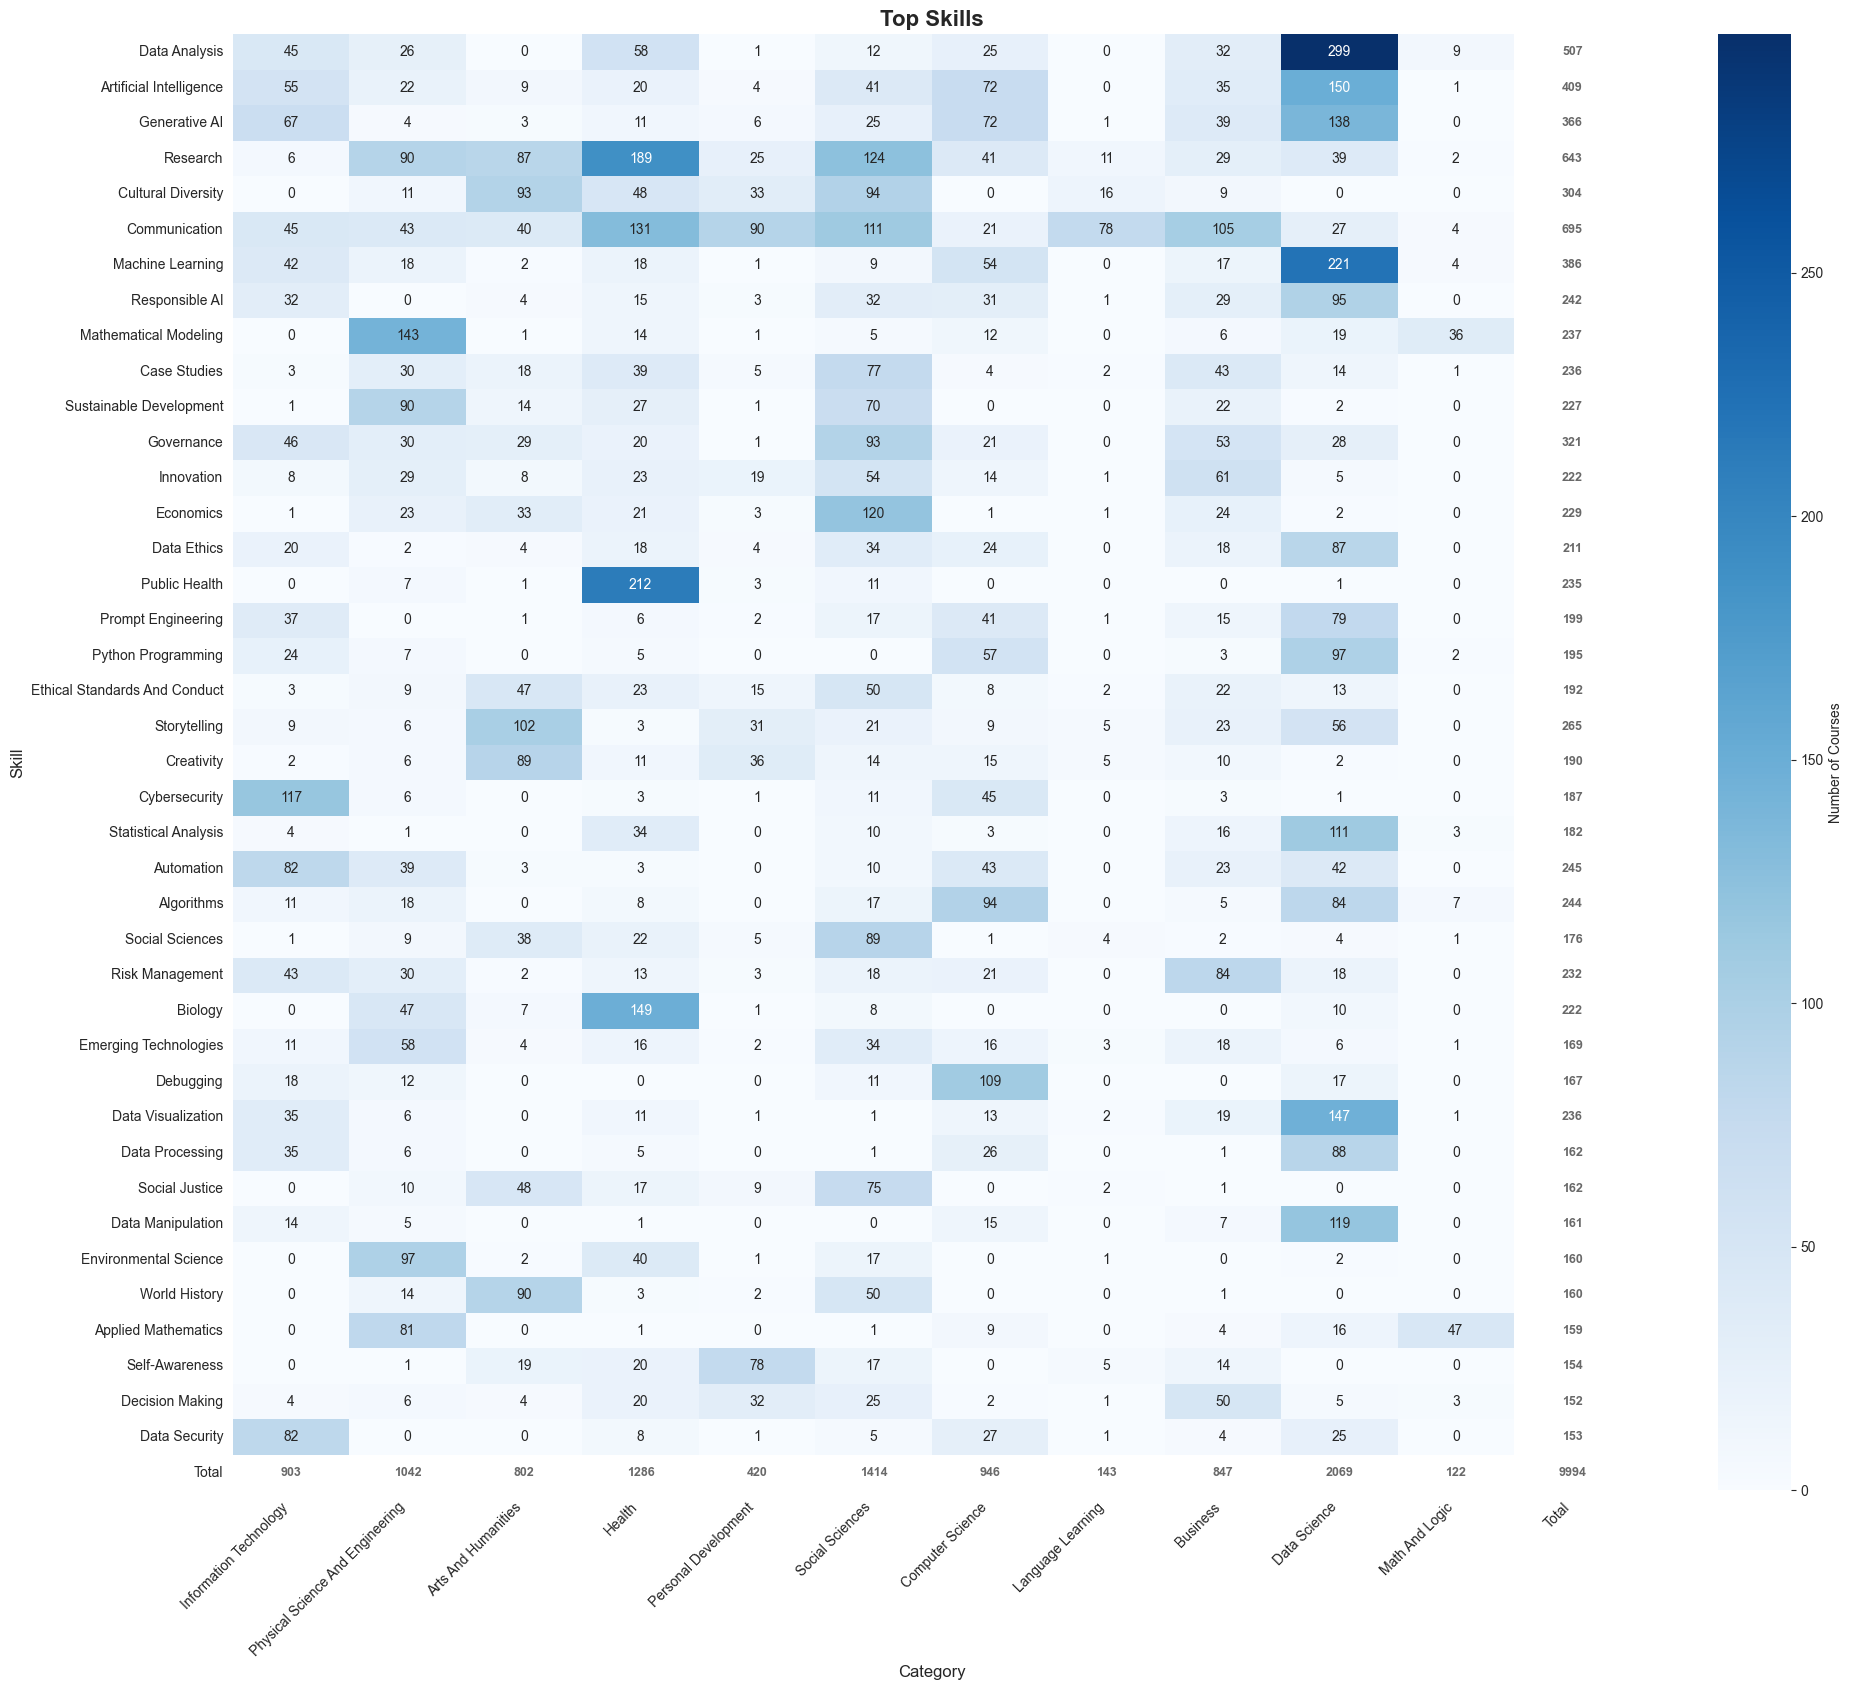

In [13]:
# Create a matrix of top 30 skills vs categories
top_n_skills = skills_series.value_counts().head(40).index

# Initialize matrix to store counts
skill_category_matrix = []

for skill in top_n_skills:
    skill_counts = []
    for category in df['category'].unique():
        # Count how many times this skill appears in this category
        category_courses = df[df['category'] == category]
        count = 0
        for skills_str in category_courses['skills'].dropna():
            if skill in skills_str:
                count += 1
        skill_counts.append(count)
    skill_category_matrix.append(skill_counts)

# Create DataFrame
skill_category_df = pd.DataFrame(skill_category_matrix, 
                                  index=top_n_skills, 
                                  columns=df['category'].unique())

# Add total row and column
skill_category_df['Total'] = skill_category_df.sum(axis=1)
skill_category_df.loc['Total'] = skill_category_df.sum(axis=0)

# Create mask for totals (True means no color)
mask = pd.DataFrame(False, index=skill_category_df.index, columns=skill_category_df.columns)
mask.loc['Total', :] = True
mask.loc[:, 'Total'] = True

# Heatmap: Top 30 Skills vs Categories with totals
fig, ax = plt.subplots(figsize=(20, 17))
sns.heatmap(skill_category_df, annot=True, fmt='g', cmap='Blues', 
            mask=mask, cbar_kws={'label': 'Number of Courses'}, ax=ax)

# Cover total cells with white rectangles
num_categories = len(skill_category_df.columns)
num_skills = len(skill_category_df.index)

for i in range(num_skills):
    rect = plt.Rectangle((num_categories - 1, i), 1, 1, fill=True, 
                         facecolor='white', edgecolor='none')
    ax.add_patch(rect)

for j in range(num_categories):
    rect = plt.Rectangle((j, num_skills - 1), 1, 1, fill=True, 
                         facecolor='white', edgecolor='none')
    ax.add_patch(rect)

# Add total annotations
for i, skill in enumerate(skill_category_df.index):
    if skill == 'Total':
        for j, cat in enumerate(skill_category_df.columns):
            plt.text(j + 0.5, i + 0.5, f'{int(skill_category_df.loc[skill, cat])}',
                    ha='center', va='center', color='dimgray', fontweight='bold', fontsize=9)
    else:
        j = num_categories - 1
        plt.text(j + 0.5, i + 0.5, f'{int(skill_category_df.loc[skill, "Total"])}',
                ha='center', va='center', color='dimgray', fontweight='bold', fontsize=9)

plt.title('Top Skills', fontsize=16, fontweight='bold')
plt.xlabel('Category', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 14. Duplicate Analysis

In [10]:
# Check for duplicate courses
duplicate_names = df[df.duplicated(subset=['name'], keep=False)]
duplicate_urls = df[df.duplicated(subset=['url'], keep=False)]

print(f"Duplicate course names: {len(duplicate_names)}")
print(f"Duplicate URLs: {len(duplicate_urls)}")
print(f"Total duplicates (exact rows): {df.duplicated().sum()}")

Duplicate course names: 77
Duplicate URLs: 0
Total duplicates (exact rows): 0


## 15. Correlation Analysis

### Category-to-Category Similarity Analysis

Analyzing how similar categories are based on their shared skill profiles.

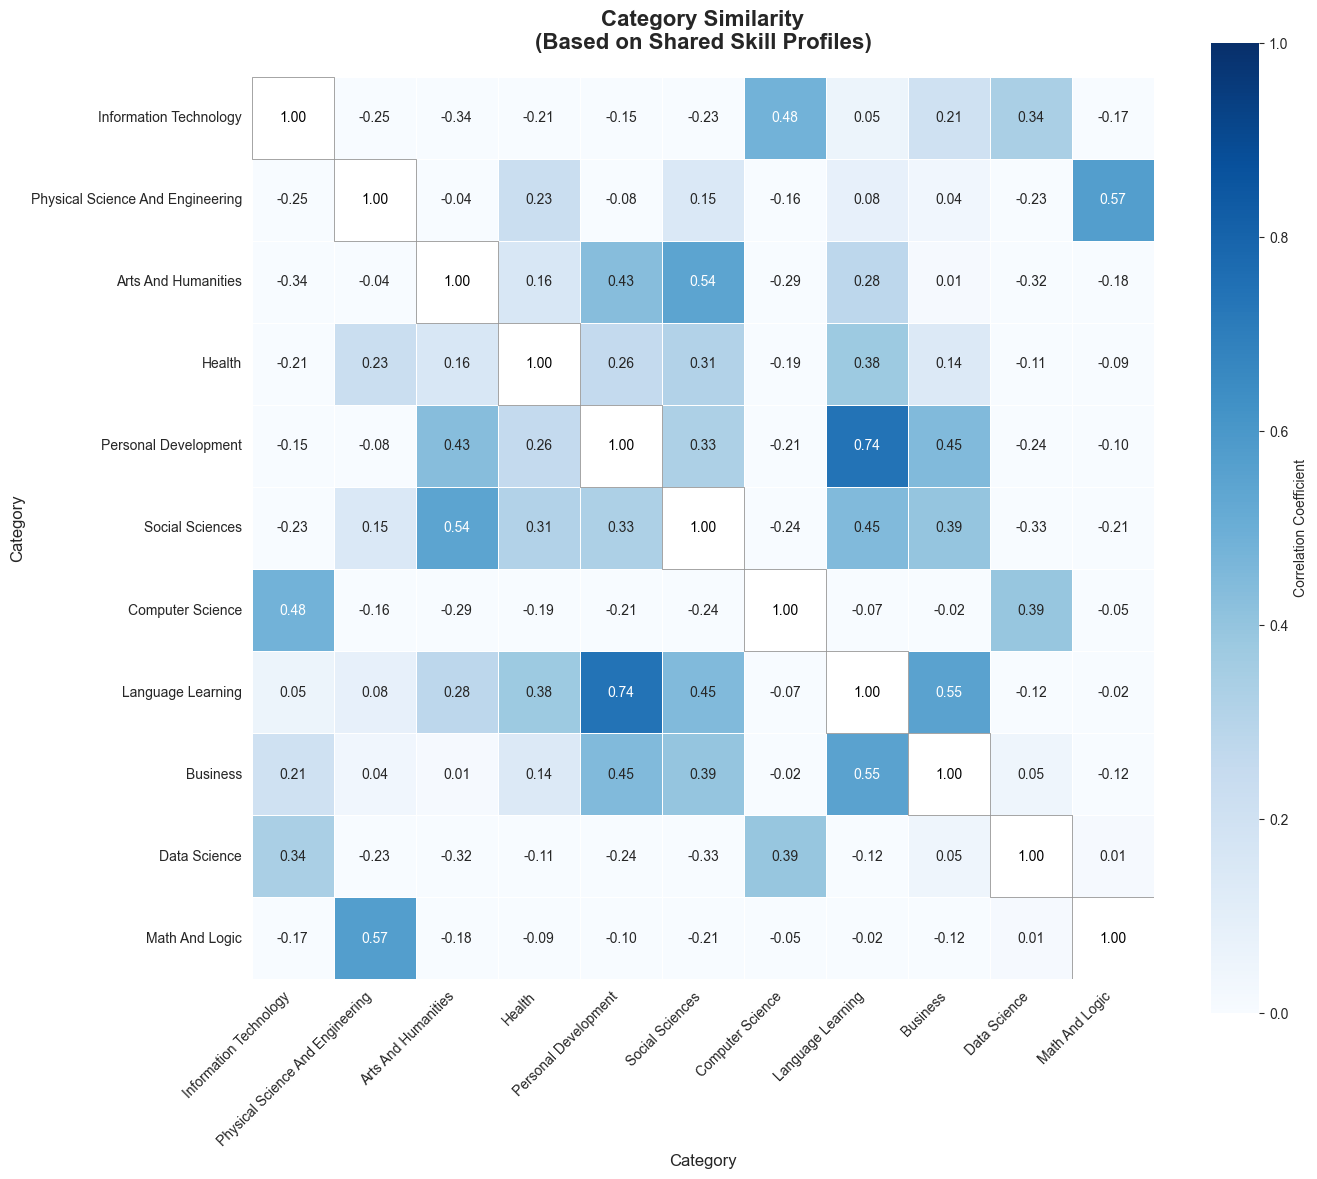

In [11]:
# Category-to-Category Correlation Matrix
# Remove 'Total' column for correlation calculation
skill_category_clean = skill_category_df.drop('Total', axis=1).drop('Total', axis=0)

# Transpose so categories are columns
category_skill_matrix = skill_category_clean.T

# Calculate correlation between categories (correlating across columns means correlating rows)
# We need to transpose first so categories become columns, then correlate
category_correlation = category_skill_matrix.T.corr()

# Find top similar pairs
corr_pairs = []
for i in range(len(category_correlation.columns)):
    for j in range(i+1, len(category_correlation.columns)):
        corr_pairs.append({
            'Category 1': category_correlation.columns[i],
            'Category 2': category_correlation.columns[j],
            'Correlation': category_correlation.iloc[i, j]
        })

corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('Correlation', ascending=False)
# print(corr_pairs_df.head(10).to_string(index=False))

# Visualize Category-to-Category Correlation Heatmap
# Create a mask for the diagonal
mask_diagonal = np.eye(len(category_correlation), dtype=bool)

plt.figure(figsize=(14, 12))
sns.heatmap(category_correlation, annot=True, fmt='.2f', cmap='Blues', 
            mask=mask_diagonal, square=True, linewidths=0.5, 
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=0, vmax=1)

# Fill diagonal with white
for i in range(len(category_correlation)):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, facecolor='white', edgecolor='gray', linewidth=0.5))
    plt.text(i + 0.5, i + 0.5, '1.00', ha='center', va='center', color='black', fontsize=10)

plt.title('Category Similarity\n(Based on Shared Skill Profiles)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# print("\nInterpretation:")
# print("- Darker blue indicates categories with very similar skill profiles")
# print("- White/light blue indicates categories with different skill profiles")
# print("- Diagonal is white (category compared with itself)")

### Skill-to-Skill Co-occurrence Analysis

Analyzing which skills tend to appear together in the same courses.

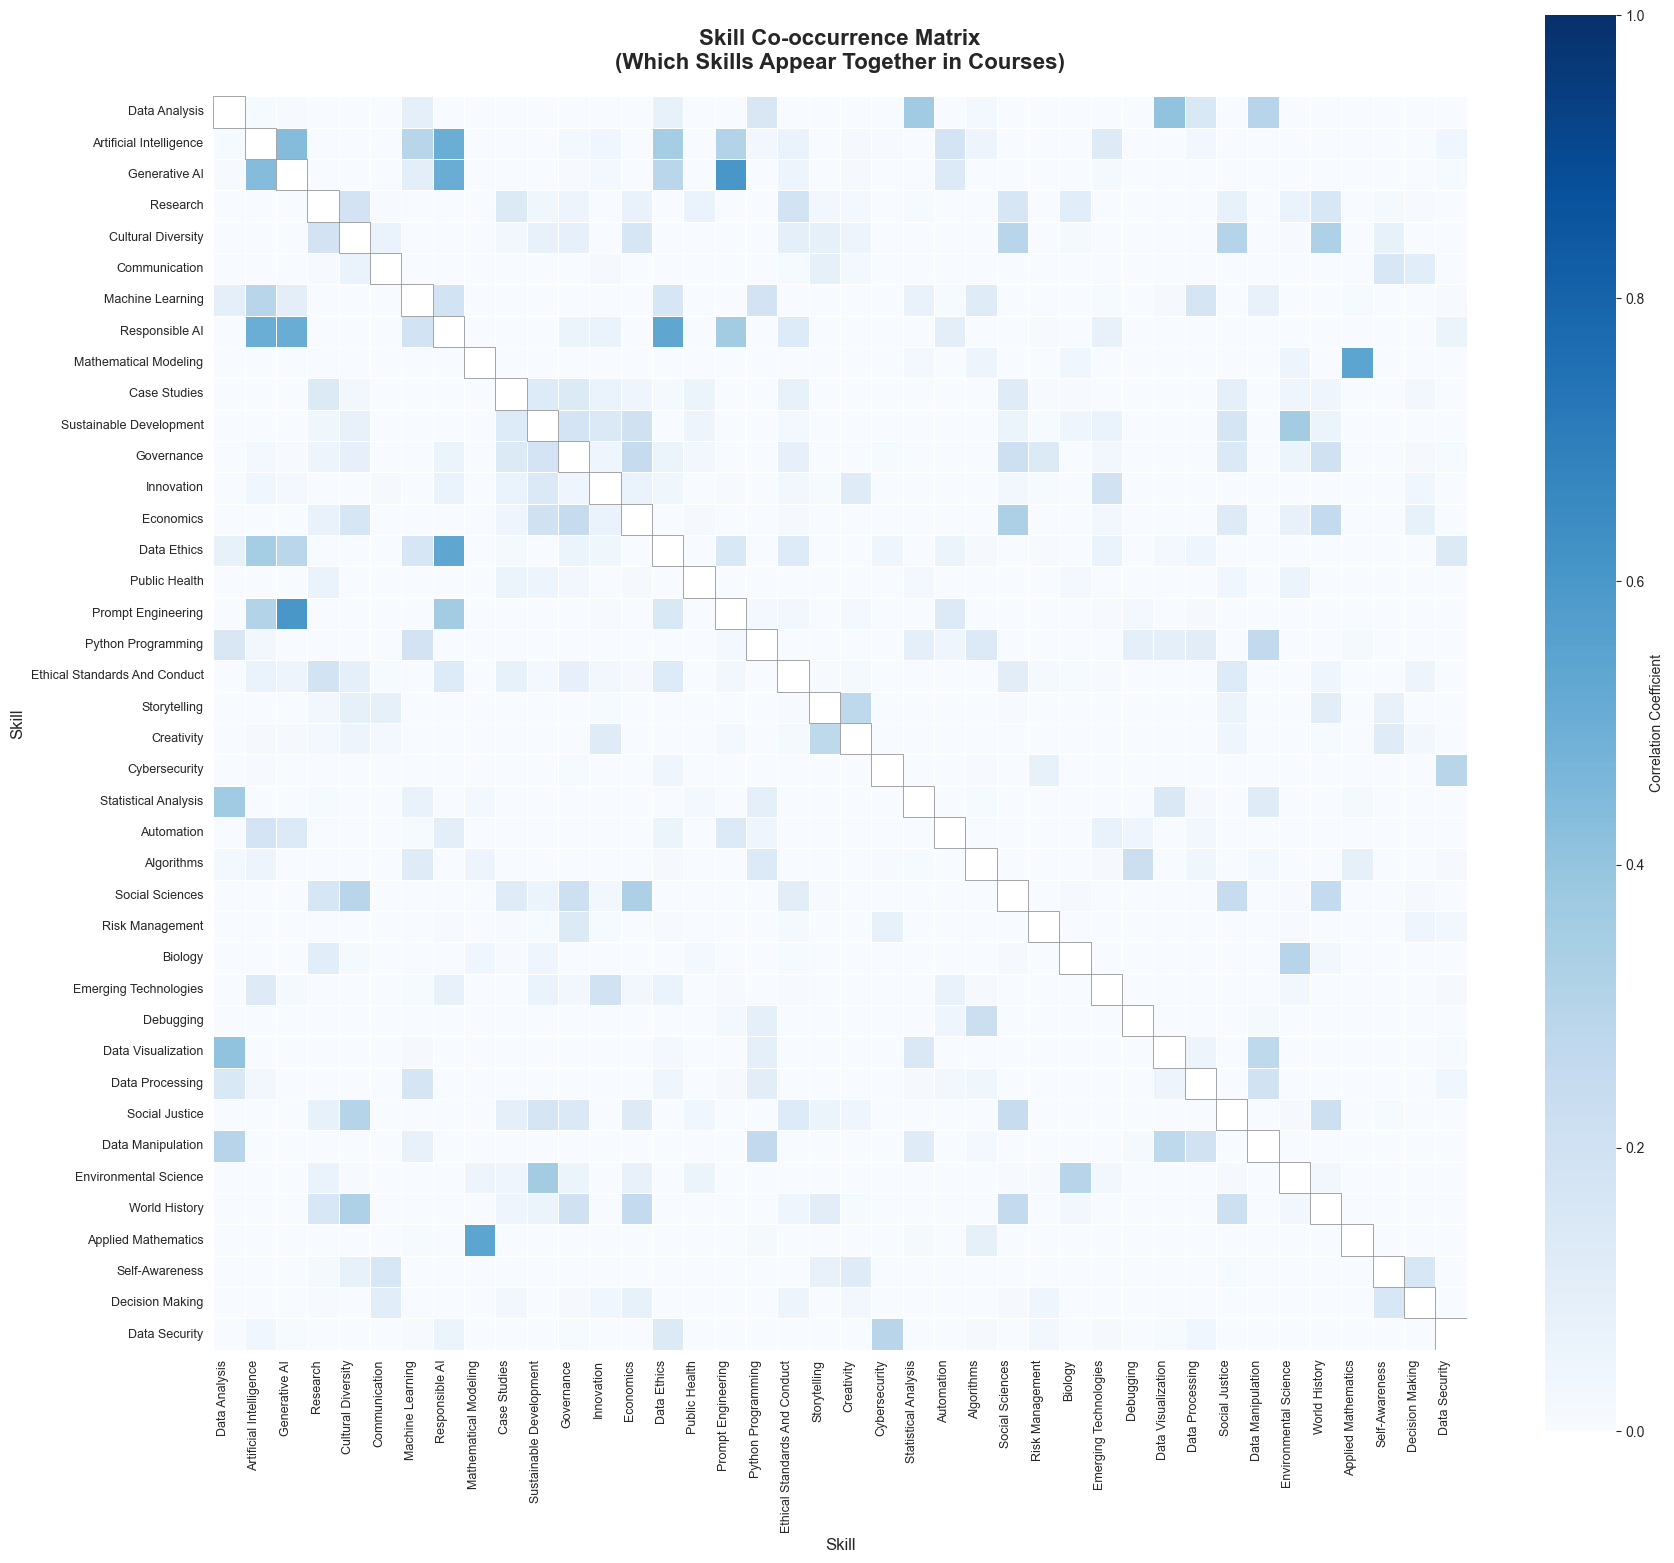

In [12]:
# Skill-to-Skill Co-occurrence Matrix
# Create a binary matrix: 1 if skill appears in course, 0 otherwise
top_n_skills_list = skills_series.value_counts().head(40).index.tolist()

# Build course-skill matrix
course_skill_matrix = []
for idx, row in df.iterrows():
    skills_in_course = []
    if pd.notna(row['skills']):
        course_skills = [skill.strip() for skill in row['skills'].split(',')]
        skills_in_course = [1 if skill in course_skills else 0 for skill in top_n_skills_list]
    else:
        skills_in_course = [0] * len(top_n_skills_list)
    course_skill_matrix.append(skills_in_course)

course_skill_df = pd.DataFrame(course_skill_matrix, columns=top_n_skills_list)

# Calculate correlation between skills (which skills co-occur)
skill_correlation = course_skill_df.corr()

# Find top co-occurring skill pairs
skill_pairs = []
for i in range(len(skill_correlation.columns)):
    for j in range(i+1, len(skill_correlation.columns)):
        if skill_correlation.iloc[i, j] > 0.3:  # Only pairs with correlation > 0.3
            skill_pairs.append({
                'Skill 1': skill_correlation.columns[i],
                'Skill 2': skill_correlation.columns[j],
                'Correlation': skill_correlation.iloc[i, j]
            })

skill_pairs_df = pd.DataFrame(skill_pairs).sort_values('Correlation', ascending=False)
# print(skill_pairs_df.head(15).to_string(index=False))

# Visualize Skill-to-Skill Correlation Heatmap
# Create a mask for the diagonal
mask_diagonal_skill = np.eye(len(skill_correlation), dtype=bool)

plt.figure(figsize=(18, 16))
sns.heatmap(skill_correlation, annot=False, cmap='Blues', 
            mask=mask_diagonal_skill, square=True, linewidths=0.5, 
            cbar_kws={'label': 'Correlation Coefficient'},
            vmin=0, vmax=1)

# Fill diagonal with white
for i in range(len(skill_correlation)):
    plt.gca().add_patch(plt.Rectangle((i, i), 1, 1, fill=True, facecolor='white', edgecolor='gray', linewidth=0.5))

plt.title('Skill Co-occurrence Matrix\n(Which Skills Appear Together in Courses)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Skill', fontsize=12)
plt.ylabel('Skill', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()

# print("\nInterpretation:")
# print("- Darker blue: skills that frequently appear together")
# print("- White/light blue: skills that rarely appear in the same courses")
# print("- Diagonal is white (skill compared with itself)")
# print("- Useful for skill recommendations: if a course has skill A, it likely has skill B")